# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

**Note:** The code above was pre-populated based on the previous exercise

**Part 1:** Setup and Introduction

         index  sat_score                    desc
35        rr_s   0.232199    Student Response (%)
36        rr_t  -0.023386    Teacher Response (%)
37        rr_p   0.047925     Parent Response (%)
38         N_s   0.423463    Student Response (#)
39         N_t   0.291463    Teacher Response (#)
40         N_p   0.421530     Parent Response (#)
41    saf_p_11   0.122913    Safety & Respect (P)
42    com_p_11  -0.115073       Communication (P)
43    eng_p_11   0.020254          Engagement (P)
44    aca_p_11   0.035155        Academic Exp (P)
45    saf_t_11   0.313810    Safety & Respect (T)
46    com_t_11   0.082419       Communication (T)
47    eng_t_10        NaN          Engagement (T)
48    aca_t_11   0.132348        Academic Exp (T)
49    saf_s_11   0.337639    Safety & Respect (S)
50    com_s_11   0.187370       Communication (S)
51    eng_s_11   0.213822          Engagement (S)
52    aca_s_11   0.339435        Academic Exp (S)
53  saf_tot_11   0.318753  Safety & Respect (Ave)


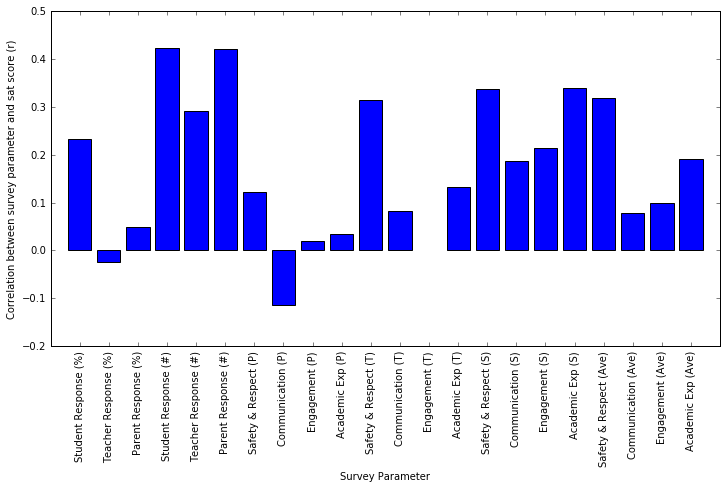

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

survey_desc = ['Student Response (%)', 'Teacher Response (%)', 'Parent Response (%)', \
              'Student Response (#)','Teacher Response (#)', 'Parent Response (#)', \
              'Safety & Respect (P)', 'Communication (P)', 'Engagement (P)', 'Academic Exp (P)', \
              'Safety & Respect (T)', 'Communication (T)', 'Engagement (T)', 'Academic Exp (T)', \
              'Safety & Respect (S)', 'Communication (S)', 'Engagement (S)', 'Academic Exp (S)', \
              'Safety & Respect (Ave)', 'Communication (Ave)', 'Engagement (Ave)', 'Academic Exp (Ave)', \
              ]

corr_df = correlations.to_frame().reset_index()
in_survey = corr_df["index"].apply(lambda x: x in survey_fields)
corr_in_survey = corr_df.loc[in_survey]
corr_in_survey = corr_in_survey.assign(desc = survey_desc)
print(corr_in_survey)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
ax.bar(range(len(corr_in_survey["sat_score"])), corr_in_survey["sat_score"], align="center")
ax.set_xlim(-1,22)
ax.set_xticks(range(0,22,1))
ax.set_xticklabels(survey_desc, rotation=90)
ax.set_xlabel("Survey Parameter")
ax.set_ylabel("Correlation between survey parameter and sat score (r)")

plt.show()

**Discussion:** The dataset plotted above is from a survey of student, teacher, and parent opinions about their schools. Each survey parameter is plotted against its correlation with student sat scores. Most of the correlations are too weak to much faith in, just based on the raw numbers (each would need to be looked at in detail to evaluate further). However, the strongest correlations appear to be between total survey response numbers and sat scores. The survey response rates themselves do not correlate, suggesting that, instead of being a measure of relative involvement or interest, the relationship is actually a function of school size. A few other notable correlations can be oberseved between student and teacher opinions about school safety, but the bar chart alone is not  robust enough to make many inferences.

**Part 2:** Safety and SAT Scores

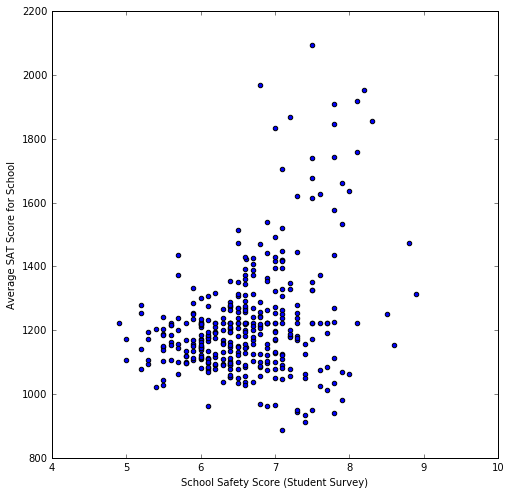

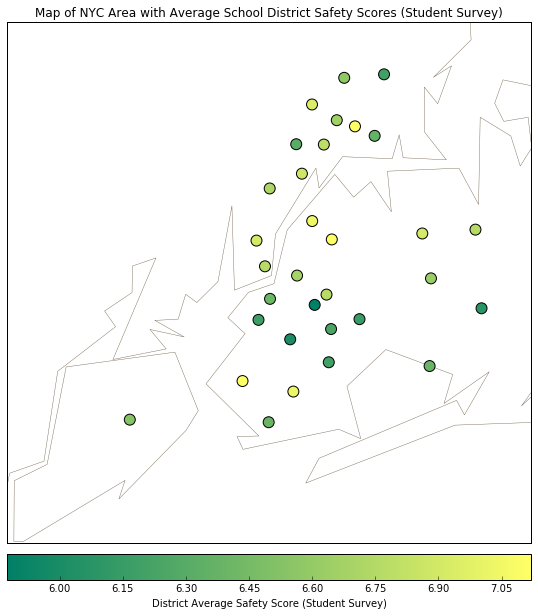

In [64]:
# Scatter plot of SAT Scores vs Student Safety Scores
fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(1,1,1)
ax1.scatter(x=combined["saf_s_11"], y=combined["sat_score"])
ax1.set_xlabel('School Safety Score (Student Survey)')
ax1.set_ylabel("Average SAT Score for School")
plt.show()

# Map of district average safety scores
from mpl_toolkits.basemap import Basemap

fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(1,1,1)
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
ax2.set_axis_bgcolor('white')
ax2.set_title("Map of NYC Area with Average School District Safety Scores (Student Survey)")

districts = combined.groupby("school_dist")
districts = districts.agg(numpy.mean)
districts.reset_index(inplace=True)

longitudes = list(districts["lon"])
latitudes = list(districts["lat"])

data_plot = m.scatter(longitudes, latitudes, c=districts["saf_s_11"], cmap="summer", s=120, zorder=2, latlon=True)
cbar = m.colorbar(data_plot,location="bottom",pad="2%")
cbar.set_label("District Average Safety Score (Student Survey)")
plt.show()

**Discussion:** Based on the scatterplot between school safety score and SAT score, the apparent correlation is not likely robust. The r value is dominated by a cluster of schools that happen to fall at high SAT scores and high safety scores, but the rest of the data does not seem to fall on a nice continuum over the range of values. That cloud of high values is likely better explained by another variable or set of variables. One way to test the robustness of the correlation is to do Monte Carlo simulations and determine the frequency wih which a set of samples with that distribution and clustering will occur from an underlying population that is uncorrelated.

The second plot is a map of district-averaged safety scores for NYC. You can see that the students tend to feel safer near Manhattan and tend to feel more at risk near the border between Brooklyn and Queens. 

**Part 3:** Race and SAT Scores

SCHOOL ETHNIC MAKEUP VS SAT SCORES IN NYC




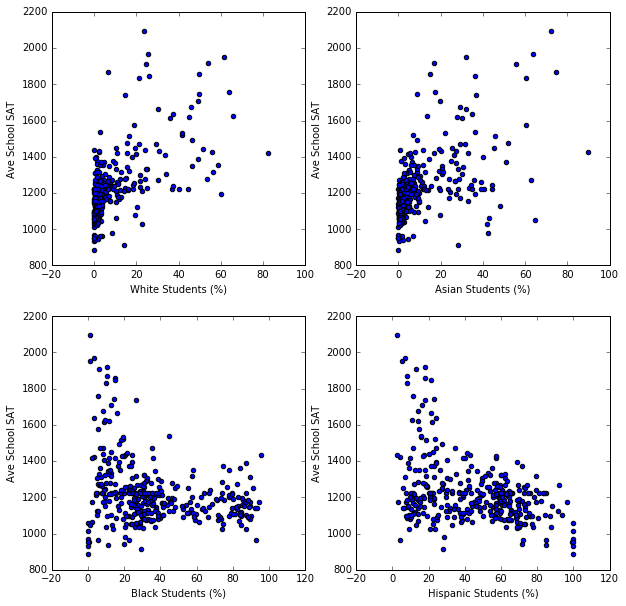



SCHOOLS WITH > 95% HISPANIC STUDENTS


44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


SCHOOLS WITH < 10% HISPANIC STUDENTS AND > 1800 SAT SCORES


37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [69]:
# Scatter plots of SAT Scores vs ethnic makeup
fig1 = plt.figure(figsize=(10,10))
ax_white = fig1.add_subplot(2,2,1)
ax_asian = fig1.add_subplot(2,2,2)
ax_black = fig1.add_subplot(2,2,3)
ax_hispa = fig1.add_subplot(2,2,4)

ax_white.scatter(x=combined["white_per"], y=combined["sat_score"])
ax_white.set_xlabel('White Students (%)')
ax_white.set_ylabel("Ave School SAT")

ax_asian.scatter(x=combined["asian_per"], y=combined["sat_score"])
ax_asian.set_xlabel('Asian Students (%)')
ax_asian.set_ylabel("Ave School SAT")

ax_black.scatter(x=combined["black_per"], y=combined["sat_score"])
ax_black.set_xlabel('Black Students (%)')
ax_black.set_ylabel("Ave School SAT")

ax_hispa.scatter(x=combined["hispanic_per"], y=combined["sat_score"])
ax_hispa.set_xlabel('Hispanic Students (%)')
ax_hispa.set_ylabel("Ave School SAT")

print("SCHOOL ETHNIC MAKEUP VS SAT SCORES IN NYC")
print('\n')
plt.show()

# Find all schools with >95% hispanic students
has_gt_95_hisp = (combined["hispanic_per"] > 95)
gt_95_hisp = combined["SCHOOL NAME"].loc[has_gt_95_hisp]
print('\n')
print("SCHOOLS WITH > 95% HISPANIC STUDENTS")
print('\n')
print(gt_95_hisp)

# Find all schools with <10% hispanic students and >1800 SAT score
has_lt_10_hisp_gt_1800 = (combined["hispanic_per"] < 10) & (combined['sat_score'] > 1800)
lt_10_hisp_gt_1800 = combined["SCHOOL NAME"].loc[has_lt_10_hisp_gt_1800]
print('\n')
print("SCHOOLS WITH < 10% HISPANIC STUDENTS AND > 1800 SAT SCORES")
print('\n')
print(lt_10_hisp_gt_1800)

**Discussion:** There are definitely correlations between ethnic makeups of schools and average SAT scores. Scores correlate positively with percentages of whites and asians and negatively with percentages of blacks and hispanics. Having said that, it's not clear from this data that race itself is a causal factor. Correlations could be due to poverty (and poor schools happen to have more blacks and hispanics), overall lower educational standards of schools (also often due to poverty), racial biases of the test itself, or a combination of factors. Ideally, to determine the relationships between race and SAT scores, you'd want to look at outcomes within individual schools and you'd want to compare outcomes for similar socioeconomic factors. That would be the only method to detect an actual racial bias in the test itself.

Its worth noting that the schools that are nearly entirely comprised of hispanic students have particularly poor SAT outcomes. These schools are listed above. As best as I can tell, these schools all cater to children of recent immigrants, and for most of those students, English will be a second language. Thus, it's not hard to understand why those students would perform poorly on an English-language test.

Finally, the schools that have less than 10% hispanic students and higher than 1800 SAT scores appear to be mostly magnet schools or highly competitive schools focussing on STEM education.

**Part 4:** Gender and SAT Scores

SCHOOL GENDER MAKEUP VS SAT SCORES IN NYC




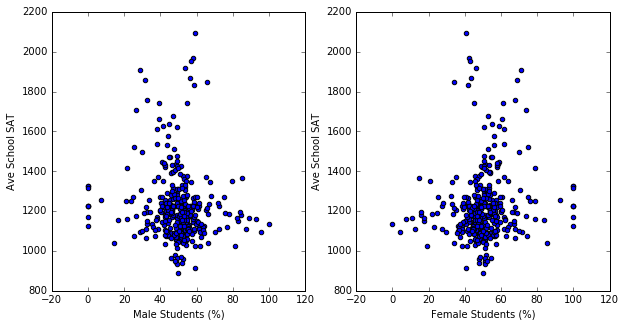



SCHOOLS WITH > 60% FEMALE STUDENTS AND > 1700 SAT SCORES


5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [73]:
# Scatter plots of SAT Scores vs gender makeup
fig1 = plt.figure(figsize=(10,5))
ax_men = fig1.add_subplot(1,2,1)
ax_wom = fig1.add_subplot(1,2,2)

ax_men.scatter(x=combined["male_per"], y=combined["sat_score"])
ax_men.set_xlabel('Male Students (%)')
ax_men.set_ylabel("Ave School SAT")

ax_wom.scatter(x=combined["female_per"], y=combined["sat_score"])
ax_wom.set_xlabel('Female Students (%)')
ax_wom.set_ylabel("Ave School SAT")

print("SCHOOL GENDER MAKEUP VS SAT SCORES IN NYC")
print('\n')
plt.show()

# Find all schools with >60% female students and >1700 SAT score
has_gt_60_wom_gt_1700 = (combined["female_per"] > 60) & (combined['sat_score'] > 1700)
gt_60_wom_gt_1700 = combined["SCHOOL NAME"].loc[has_gt_60_wom_gt_1700]
print('\n')
print("SCHOOLS WITH > 60% FEMALE STUDENTS AND > 1700 SAT SCORES")
print('\n')
print(gt_60_wom_gt_1700)

**Discussion:** There are no meaningful correlations between the gender makeup of schools and the average SAT scores.

The schools that have >60% women and >1700 SAT scores are selective magnet or college prep schools.

**Part 5:** AP Scores vs SAT Scores

SCHOOL AP EXAM PARTICIPATION VS SAT SCORES IN NYC




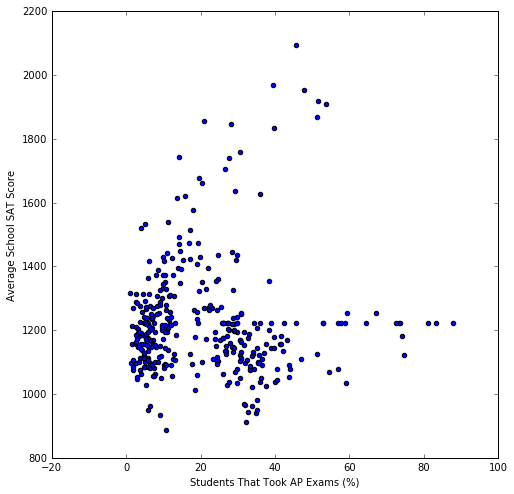

In [76]:
ap_per = 100*(combined["AP Test Takers "] / combined["total_enrollment"])
combined = combined.assign(ap_per = ap_per)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(x=combined["ap_per"],y=combined["sat_score"])
ax.set_xlabel("Students That Took AP Exams (%)")
ax.set_ylabel("Average School SAT Score")
print("SCHOOL AP EXAM PARTICIPATION VS SAT SCORES IN NYC")
print('\n')
plt.show()

**Discussion:** There isn't a good correlation between the percentage of students that took AP exams and the average SAT scores. There's also a strange group of schools that appear to have identical scores (~1200). That looks artificial and may indicate a problem with the underlying dataset.

**Part 6:** Next Steps

Some of the recommended additional work includes comparing class size to SAT scores and trying to identify cheap places with good schools. For now, I'm going to park this project and move on. I may come back to this later.